In [2]:
using LinearAlgebra  #####Son las paqueterias que uso, para instalar una paqueteria basta colocar Pkg.add("Nombre_de_la_paqueteria")
using Plots
using SpecialFunctions: gamma
using Random, Distributions

In [3]:
function OUH(x0::Float64,γ::Float64,t::AbstractArray,Δt::Float64) #Proceso de Ornstein–Uhlenbeck
    x=Vector{Float64}(undef, length(t)) #Definimos un vector lleno de basura para luego sobre escribir en el 
    x[1]=x0                             #La primera entrada es la condicion inicial del Proceso de Ornstein–Uhlenbeck 
    for i=1:length(t)-1                 #Usamos un for para poder hacer el proceso
        x0=x0-(x0*γ*Δt)+(sqrt(2*Δt)*randn()) # Es el proceso de Ornstein–Uhlenbeck que depende del paso anterior 
        @inbounds x[1+i]=x0                 #@inbounds ignora si la lista tiene el tamaño adecuado y sobreescribimos en la lista basura
    end
    return x# Devolvemos la caminata de Ornstein–Uhlenbeck
end

OUH (generic function with 1 method)

In [3]:
function eigen2(n::Int64,K::Array{Float64,1},Δs::Float64) #Obtenemos los eigenvalores y eigenvectores 
    R=diagm(0 =>ones(2))                                #Hacemos una matriz llena de unos en la diagonal de dimension 2
    for i=1:n                                           #Hacemos un for donde n es la cantidad de pasos de t, pasos de tiempo
       R=(diagm(0 => ones(2))+diagm(1 => [K[i]]*Δs,-1 => -[K[i]]*Δs)+(0.5*diagm(1 => [K[i]]*Δs,-1 => -[K[i]]*Δs)^2))*R #Hacemos los pasos de multiplicar la matriz por la matriz anterior 
    end
    eigen(R)        #Obtenemos el eigenvalor y eigenvector
end

eigen2 (generic function with 1 method)

In [4]:
function lam_eigenvals(γ::Float64,x0::Float64,Δt::Float64,t::AbstractArray,Δs::Float64,tiradas::Int64) #Da una lista de eigenvalores de todas las tiradas
    λ=Vector{Complex{Float64}}(undef,2*tiradas) #Nos hace una lista llena de basura para renombrar sus valores
    for i=1:tiradas             #Un for con la cantidad de tiradas
        K=OUH(x0,γ,t,Δt)        #Usamos el proceso de Ornstein–Uhlenbeck para cada tirada
        a=eigen2(length(t),K,Δs).values #Obtenemos los eigenvalores de cada tirada
        @inbounds λ[2*i-1]=a[1] #Reescribirmos la basura con los eigenvalores
        @inbounds λ[2*i-0]=a[2] #Reescribirmos la basura con los eigenvalores
    end
    return λ   #Devolvemos la lista de eigenvalores
end

lam_eigenvals (generic function with 1 method)

In [5]:
function Mat(n::Int64,K::Array{Float64,1},Δs::Float64) #Solo muestra las matrices despues de ser multiplicadas
    R=diagm(0 =>ones(2))
    for i=1:n
       R=(diagm(0 => ones(2))+diagm(1 => [K[i]]*Δs,-1 => -[K[i]]*Δs)+(0.5*diagm(1 => [K[i]]*Δs,-1 => -[K[i]]*Δs)^2))*R
    end
    R
end

Mat (generic function with 1 method)

In [6]:
function Trayectoria(γ::Float64, x0::Float64,Δt::Float64,Δs::Float64,t::AbstractArray,sq::Float64=1.0) #Funcion que pinta las trayectorias
    K=OUH(x0,γ,t,Δt);   #Hace el proceso de Ornstein–Uhlenbeck
    T0=(eigen2(2,K,Δs).vectors)[:,2] #Es el vector tangente inicial
    N0=(eigen2(2,K,Δs).vectors)[:,1]*im #Es el vector normal inicial
    #####################
    T=Array{Float64,1}[]   #Lista vacia para todos los vectores tangentes
    N=Array{Float64,1}[]   #Lista vacia para todos los vectores normales
    for i=1:length(t)      #For que dura todos los pasos de tiempo
        T1=Mat(i,K,Δs)*T0  #Genera todos los vecotres tangentes a partir del inicial
        N1=Mat(i,K,Δs)*N0  #Genera todos los vecotres normales a partir del inicial
        push!(T,real(T1)) #Coloca los vectores tangentes en una lista
        push!(N,real(N1)) #Coloca los vectores normales en una lista
    end
    T=transpose(hcat(T...))   #Transforma T en algo mejor
    N=transpose(hcat(N...));  #Transforma B en algo mejor
    #####################
    Tx=T[:,1]               #Solo selecciona las componentes x de la lista de las tangentes
    Ty=T[:,2]               #Solo selecciona las componentes y de la lista de las tangentes
    #####################
    rx=Float64[]            #Lista vacia para la trayectoria en x
    ry=Float64[]            #Lista vacia para la trayectoria en y
    r1x=0.0                 #El punto inicial para la trayectoria en x
    r1y=0.0                 #El punto inicial para la trayectoria en y
    for i=1:length(t)       #Integral de rieman seccion por seccion
        r1x=(Tx[i])*Δs+r1x  
        r1y=(Ty[i])*Δs+r1y
        push!(rx,r1x)
        push!(ry,r1y)
    end
    r=[rx,ry]
    T=[Tx,Ty]
    N=[N[:,1],N[:,2]]
    return r,T,N
end
##########################################
##########################################
##########################################
function Trayectoria!(γ::Float64, x0::Float64,Δt::Float64,Δs::Float64,t::AbstractArray,sq::Float64=1.0)
    K=OUH(x0,γ,t,Δt);
    #K=ones(2001)*5
    T0=(eigen2(2,K,Δs).vectors)[:,2]
    N0=(eigen2(2,K,Δs).vectors)[:,1]*im
    #####################
    T=Array{Float64,1}[]
    N=Array{Float64,1}[]
    for i=1:length(t)
        T1=Mat(i,K,Δs)*T0
        N1=Mat(i,K,Δs)*N0
        push!(T,real(T1))
        push!(N,real(N1))
    end
    T=transpose(hcat(T...))
    N=transpose(hcat(N...));
    #####################
    Tx=T[:,1]
    Ty=T[:,2]
    #####################
    rx=Float64[]
    ry=Float64[]
    r1x=0.0
    r1y=0.0
    for i=1:length(t)
        r1x=(Tx[i])*Δs+r1x
        r1y=(Ty[i])*Δs+r1y
        push!(rx,r1x)
        push!(ry,r1y)
    end
    return plot!(rx,ry,legend=false,aspect_ratio=:equal,xlims=(-sq,sq),ylims=(-sq,sq),title="Trayectorias x0=$(x0)")
end

Trayectoria! (generic function with 2 methods)

In [35]:
γ=1.0
tiradas=500
x0=100.0
Δt=0.001
N=10.0
t=0:Δt:N
Δs=Δt
step=100 #Para animar
length(1:step:length(t))


101

In [36]:
@time λ=lam_eigenvals(γ,x0,Δt,t,Δs,tiradas);

 29.508200 seconds (255.04 M allocations: 12.483 GiB, 8.72% gc time)


In [37]:
l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)")
Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100)
Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100)
Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Norma")
plot(Q1,Q2,Q3,Q4,layout=l);
#savefig("Eigenvalores_Completo_2D_x0=$(x0).png")

In [38]:
scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)");
#savefig("Eigenvalores_2D_x0=$(x0).png")

In [39]:
histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Norma");
#savefig("Eigenvalores_Norma_2D_x0=$(x0).png")

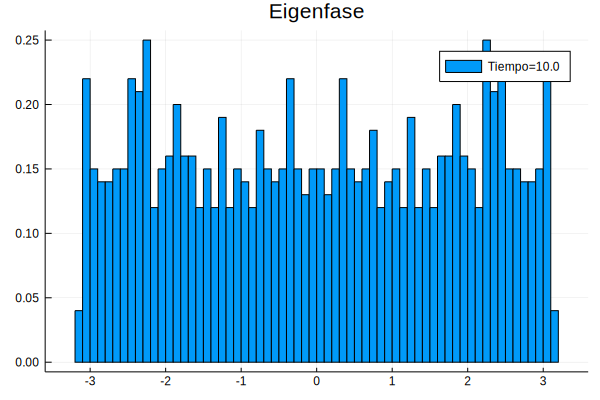

In [40]:
histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(N)",title="Eigenfase")
#savefig("Eigenvalores_Fases_2D_x0=$(x0).png")

932.478336 seconds (12.89 G allocations: 631.059 GiB, 11.31% gc time)


┌ Info: Saved animation to 
│   fn = C:\Users\sebas\Desktop\tesis\Animacion_Prueba_2D_x0=0.0.gif
└ @ Plots C:\Users\sebas\.julia\packages\Plots\qZHsp\src\animation.jl:98


Plots.AnimatedGif("C:\\Users\\sebas\\Desktop\\tesis\\Animacion_Prueba_2D_x0=0.0.gif")
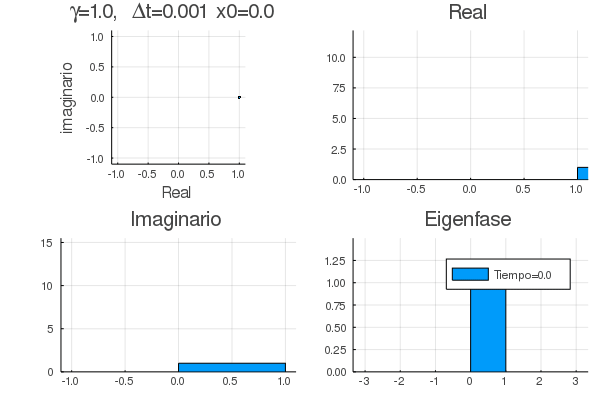

In [166]:
@time begin    
    anim= @animate for j=2:step:length(t)
        λ=lam_eigenvals(γ,x0,Δt,t[1:j],Δs,tiradas);
        l = @layout grid(2,2,heights=[0.5,0.5,0.5,0.5])
        Q3=histogram(imag(λ),normalized=true,title="Imaginario",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,15.5))
        Q2=histogram(real(λ),normalized=true,title="Real",legend=false,bins=100,xlims=(-1.1,1.1),ylims=(0,12.2))
        Q1=scatter(real(λ),imag(λ),legend=false,aspect_ratio=:equal,markersize=1,xlabel="Real",ylabel="imaginario",title="\\gamma=$γ, \\Deltat=$(Δt) x0=$(x0)",xlims=(-1.1,1.1),ylims=(-1.1,1.1))
        #Q4=histogram(abs.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Norma",xlims=(1.000,1.0034))
        Q4=histogram(angle.(λ),normalized=true,bins=60,label="Tiempo=$(t[j])",title="Eigenfase",xlims=(-(π+0.2),π+0.2),ylims=(0,1.5))
        plot(Q1,Q2,Q3,Q4,layout=l)
    end
    gif(anim,"./Animacion_Prueba_2D_x0=$(x0).gif", fps=120)
end

In [41]:
@time r,T,N=Trayectoria(γ,x0,Δt,Δs,t,5.0);

636.897421 seconds (5.10 G allocations: 248.936 GiB, 8.68% gc time)


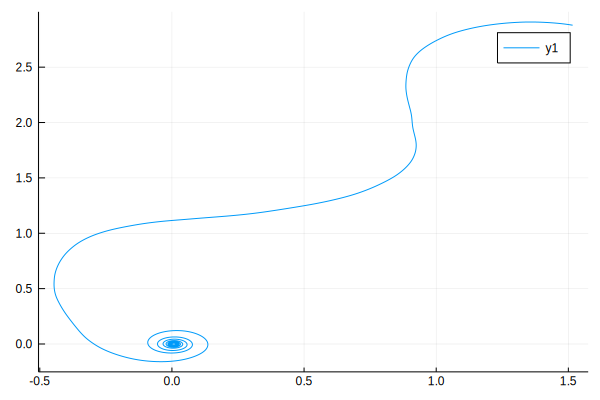

In [42]:
plot(r[1],r[2])

In [17]:
function mitad_de_lista(L)
    Ln=Float64[]
    for i=1:length(L)
        if i%2 != 0.0
            push!(Ln,L[i])
        end
    end
    return Ln
end

mitad_de_lista (generic function with 1 method)

In [60]:
T[1]=mitad_de_lista(T[1])
T[2]=mitad_de_lista(T[2])

N[1]=mitad_de_lista(N[1])
N[2]=mitad_de_lista(N[2])

r[1]=mitad_de_lista(r[1])
r[2]=mitad_de_lista(r[2])


20-element Array{Float64,1}:
  0.0007035712472806149
  0.0030920679121045954
  0.01644238621843862  
 -0.016547980056265097 
 -0.04896369143865314  
 -0.07777402510389038  
  0.11886747940166772  
 -0.14894001800979706  
 -0.012685925886911704 
  0.3249701487221894   
  0.6848735147065355   
  1.000829809511348    
  1.1274096827869862   
  1.2153719070272675   
  1.3862584646840357   
  1.692396927240902    
  2.054345498054597    
  2.416511659106465    
  2.7508195790225183   
  2.9066497838593928   

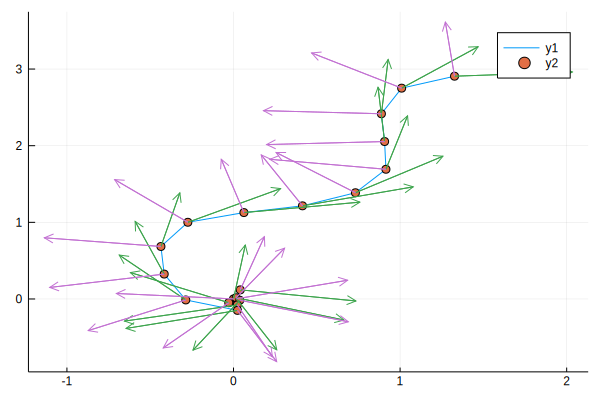

In [66]:
sq=1
plot(r[1],r[2])
scatter!(r[1],r[2])
quiver!(r[1],r[2],quiver=(T[1],T[2]))
quiver!(r[1],r[2],quiver=(N[1],N[2]))

In [202]:
savefig("Trayectorias_2D_x0=$(x0).png")

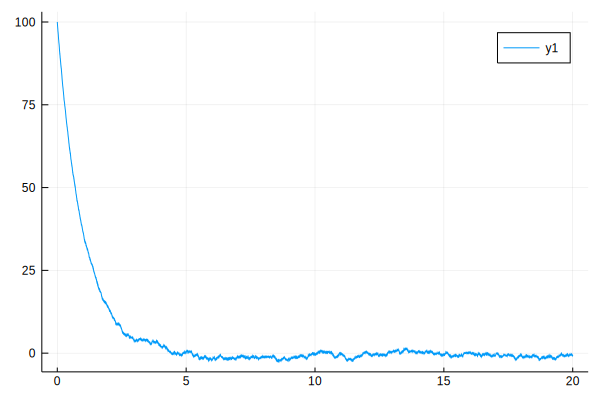

In [7]:
Δt=0.001
N=20.0
t=0:Δt:N
plot(t,OUH(100.0,1.0,t,Δt))